In [28]:
import csv
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# **IT1244 Project: Breast Cancer Classification**

**Objective:**
The objective of this project is to effectively identify whether a patient is suffering from Breast Cancer using Machine Learning Algorithms

The dataset:
[Breast Cancer Dataset](https://drive.google.com/file/d/1kr0sCKIRcXrPWwSgcMvfnaTL838sE9h-/view?usp=share_link)

# **Load Dataset**

In [ ]:
#CSV reader function to read the dataset file
def read_csv(filename):
    rows = []
    with open(filename) as csvfile:
        file_reader = csv.reader(csvfile)
        for row in file_reader:
            rows.append(row)
    return rows

When you run this code, the attributes in the dataset will be extracted from the csv file and stored in the variables below:

In [ ]:
headers = read_csv('data.csv')[0] #list that contains the different headers of of the dataset
data = read_csv('data.csv')[1:] #list of lists that contains the different attributes of each patient in the dataset

#**Filtering Out Relevant Data from the Dataset**

In [ ]:
unwanted = ['id', 'diagnosis'] #list to remove attributes not involved in prediction

r_data_head = headers.copy()
#list of headers of relevant attributes
for i in unwanted:
    r_data_head.remove(i)

head_result = ['diagnosis'] #header of data containing diagnosis of each patient

#function to create an array that can be used to filter out the relevant headers
def relevant_header_selection(header, y):
    lst = []
    for i in header:
        if i in y:
            lst.append(True)
        else:
            lst.append(False)
    return np.array(lst)

#function to extract relevant data attributes from the raw dataset
def relevant_data(data, selector):
    x = np.array(data)
    return x[:, selector]

#function to convert the diagnosis into binary: 1 for malignant and 0 for benign
def binary_conversion(data):
    lst = []
    for i in data:
        if i == 'benign':
            lst.append(0)
        elif i == 'malignant':
            lst.append(1)
    return np.array(lst)

When you run this code, the relevant data will be stored in the variables below:

In [ ]:
hd_selector = relevant_header_selection(headers, r_data_head)
result_index = relevant_header_selection(headers, head_result)
result_array = relevant_data(data, result_index)

result = binary_conversion(result_array) #array containing the results of each patient
rdata = relevant_data(data, hd_selector) #array containing the different relevant attributes

# **Standardising Data**

In [ ]:
#function to standardize the dataset
def Standardize(data):
    std = StandardScaler()
    x = std.fit_transform(data)
    return x

When you run this code, the relevant data will be standardised and stored in the vairable below:

In [ ]:
std_data = Standardize(rdata)

# **Confusion Matrix Visualizer**

In [ ]:
def visualise_cm(pred, test):
    cm = confusion_matrix(test, pred)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malignant'])
    cm_disp.plot()
    plt.show()

# **Split Dataset into Training and Testing Sets**

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(std_data, result, test_size=0.25, random_state=0) #splits dataset into training and testing sets

# **Logistic Regression Model**

When you run the code below, the sklearn LogisticRegression function will be implemented and train using the training dataset. It will then predict, based on the testing dataset, whether a patient has breast cancer:

In [30]:
#Logistic Regression Model
LR = LogisticRegression()

LR.fit(X_train, Y_train)

LogisticRegression()

When you run the code below, the model is tested on the testing set and shows the visual representation of the confusion matrix as well as the prediction score

Prediction Score of Logistic Regression Model tested on Testing Set: 0.965034965034965


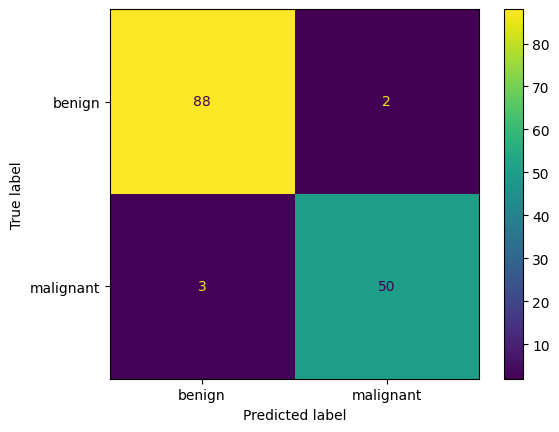

None


In [31]:
LR_pred = LR.predict(X_test)

print("Prediction Score of Logistic Regression Model tested on Testing Set:", accuracy_score(Y_test, LR_pred))
print(visualise_cm(LR_pred, Y_test))

# **Evaluator Function**

In [32]:
def lr_evaluator(X, Y, model):
    kf = KFold(10, shuffle=True, random_state=1)
    pred = np.array([])
    actual = np.array([])
    accuracy = np.array([])
    precision = np.array([])
    recall = np.array([])
    for train, test in kf.split(X):
        x_train, y_train, x_test, y_test = X[train], Y[train], X[test], Y[test]
        model.fit(x_train, y_train)
        pred_i = model.predict(x_test)
        pred = np.append(pred, pred_i)
        actual = np.append(actual, y_test)
        accuracy = np.append(accuracy, [accuracy_score(y_test, pred_i)])
        precision = np.append(precision, [precision_score(y_test, pred_i)])
        recall = np.append(recall, [recall_score(y_test, pred_i)])
    return pred, actual, accuracy, precision, recall

When you run the code below, you will get the Confusion Matrix after 10-Fold Cross Validation as well as the average metric scores:

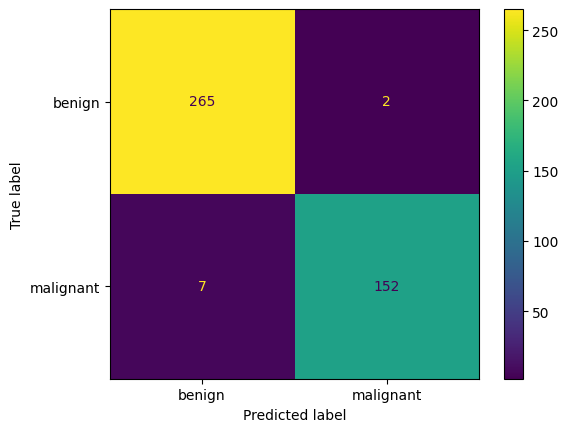

None
Average Accuracy Score after 10-fold Cross Validation for Logistic Regression: 0.9787929125138428
Average Precision Score after 10-fold Cross Validation for Logistic Regression: 0.9894736842105264
Average Recall Score after 10-fold Cross Validation for Logistic Regression: 0.95012765012765


In [33]:
pred_LR, actual_LR, accuracy_LR, precision_LR, recall_LR = lr_evaluator(X_train, Y_train, LR)

print(visualise_cm(pred_LR, actual_LR))
print("Average Accuracy Score after 10-fold Cross Validation for Logistic Regression:", accuracy_LR.mean())
print("Average Precision Score after 10-fold Cross Validation for Logistic Regression:", precision_LR.mean())
print("Average Recall Score after 10-fold Cross Validation for Logistic Regression:", recall_LR.mean())

# **k-nearest Neighbors Model**

When you run the code below, the sklearn KNeighborsClassifier function will be implemented and train using the training dataset. It will then predict, based on the testing dataset, whether a patient has breast cancer:

In [34]:
# function to find the optimal k value for k-nearest neighbors algorithm
def k_finder(X_test, Y_test, X_train, Y_train):
    error = []
    for i in range(1, len(X_test)):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, Y_train)
        pred = knn.predict(X_test)
        e = mean_absolute_error(Y_test, pred)
        error.append(e)
    return np.array(error).argmin() + 1

#KNN Model
knn = KNeighborsClassifier(n_neighbors=k_finder(X_test, Y_test, X_train, Y_train))

knn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=4)

When you run the code below, the model is tested on the testing set and shows the visual representation of the confusion matrix as well as the prediction score

Prediction Score of KNN Model tested on Testing Set: 0.958041958041958


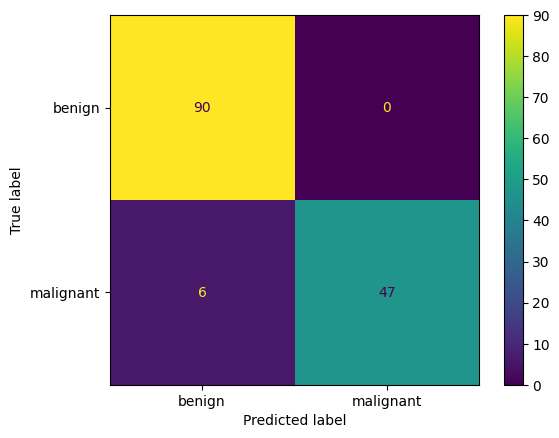

None


In [35]:
knn_pred = knn.predict(X_test)

print("Prediction Score of KNN Model tested on Testing Set:", accuracy_score(Y_test, knn_pred))
print(visualise_cm(knn_pred, Y_test))

# **Evaluator Function**

In [36]:
def knn_evaluator(X, Y, model):
    kf = KFold(10, shuffle=True, random_state=1)
    pred = np.array([])
    actual = np.array([])
    accuracy = np.array([])
    precision = np.array([])
    recall = np.array([])
    for train, test in kf.split(X):
        x_train, y_train, x_test, y_test = X[train], Y[train], X[test], Y[test]
        model.fit(x_train, y_train)
        pred_i = model.predict(x_test)
        pred = np.append(pred, pred_i)
        actual = np.append(actual, y_test)
        accuracy = np.append(accuracy, [accuracy_score(y_test, pred_i)])
        precision = np.append(precision, [precision_score(y_test, pred_i)])
        recall = np.append(recall, [recall_score(y_test, pred_i)])
    return pred, actual, accuracy, precision, recall

When you run the code below, you will get the Confusion Matrix after 10-Fold Cross Validation as well as the average metric scores:

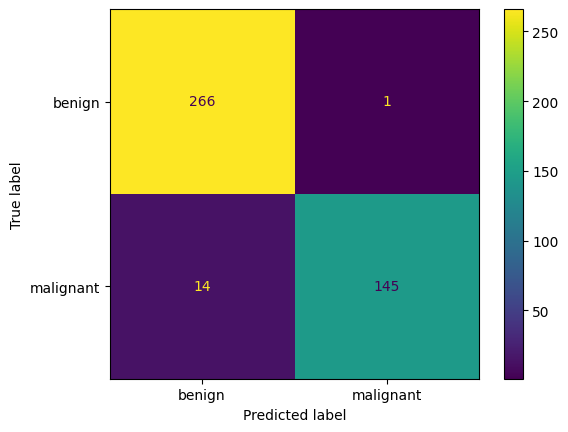

None
Average Accuracy Score after 10-fold Cross Validation for KNN: 0.9647840531561462
Average Precision Score after 10-fold Cross Validation for KNN: 0.9941176470588236
Average Recall Score after 10-fold Cross Validation for KNN: 0.9071953193005824


In [37]:
pred_knn, actual_knn, accuracy_knn, precision_knn, recall_knn = knn_evaluator(X_train, Y_train, knn)

print(visualise_cm(pred_knn, actual_knn))
print("Average Accuracy Score after 10-fold Cross Validation for KNN:", accuracy_knn.mean())
print("Average Precision Score after 10-fold Cross Validation for KNN:", precision_knn.mean())
print("Average Recall Score after 10-fold Cross Validation for KNN:", recall_knn.mean())

# **Neural Network Model**

When you run the code below, the keras neural network model will be implemented.

In [38]:
nn_model = keras.models.Sequential()
nn_model.add(keras.layers.InputLayer(input_shape = [30]))
nn_model.add(keras.layers.Dense(30,activation = 'relu'))
nn_model.add(keras.layers.Dense(1,activation = 'sigmoid'))
nn_model.compile(loss = 'mean_squared_error',optimizer = 'adam',metrics = ['accuracy'])

nn_model.fit(X_train, Y_train, batch_size=1, epochs=10, verbose=0)

When you run the code below, the model is tested on the testing set and shows the visual representation of the confusion matrix as well as the prediction score:

5/5 [==============================] - 0s 6ms/step
Prediction Score of Neural Network Model tested on Testing Set: 0.972027972027972


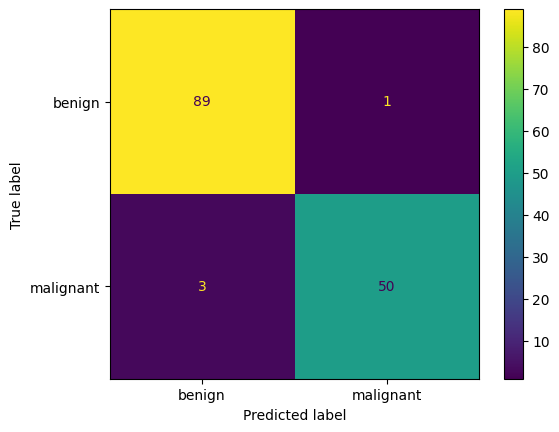

None


In [39]:
nn_pred = nn_model.predict(X_test)>0.5
print("Prediction Score of Neural Network Model tested on Testing Set:", accuracy_score(Y_test, nn_pred))
print(visualise_cm(nn_pred, Y_test))

# **Evaluator Function**

In [40]:
def nn_evaluator(X, Y, model):
    kf = KFold(10, shuffle=True, random_state=1)
    pred = np.array([])
    actual = np.array([])
    accuracy = np.array([])
    precision = np.array([])
    recall = np.array([])
    for train, test in kf.split(X):
        x_train, y_train, x_test, y_test = X[train], Y[train], X[test], Y[test]
        model.fit(x_train,y_train,batch_size = 1,epochs = 10,verbose = 0)
        pred_i = model.predict(x_test) > 0.5
        pred = np.append(pred, pred_i)
        actual = np.append(actual, y_test)
        accuracy = np.append(accuracy, [accuracy_score(y_test, pred_i)])
        precision = np.append(precision, [precision_score(y_test, pred_i)])
        recall = np.append(recall, [recall_score(y_test, pred_i)])
    return pred, actual, accuracy, precision, recall

When you run the code below, you will get the Confusion Matrix after 10-Fold Cross Validation as well as the average metric scores:

2/2 [==============================] - 0s 5ms/step


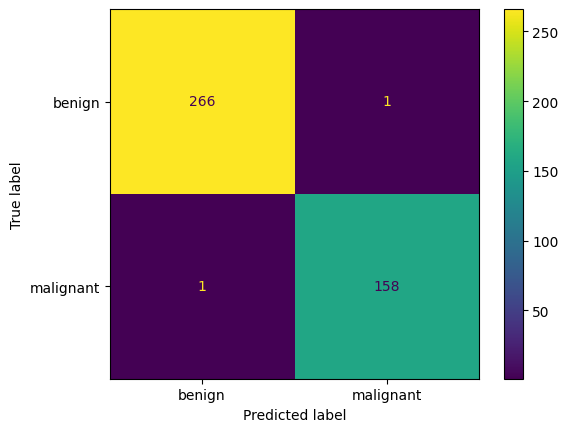

None
Average Accuracy Score after 10-fold Cross Validation for NN: 0.9952934662236987
Average Precision Score after 10-fold Cross Validation for NN: 0.9947368421052631
Average Recall Score after 10-fold Cross Validation for NN: 0.9928571428571429


In [41]:
pred_nn, actual_nn, accuracy_nn, precision_nn, recall_nn = nn_evaluator(X_train, Y_train, nn_model)

print(visualise_cm(pred_nn, actual_nn))
print("Average Accuracy Score after 10-fold Cross Validation for NN:", accuracy_nn.mean())
print("Average Precision Score after 10-fold Cross Validation for NN:", precision_nn.mean())
print("Average Recall Score after 10-fold Cross Validation for NN:", recall_nn.mean())

# **Varying Threshold to Optimise Recall Score**

In [52]:
#Recall Optimisation Evaluator for Logistic Regression & KNN
def evaluator_diff_th(X, Y, model):
    kf = KFold(10, shuffle=True, random_state=1)
    pred = np.array([])
    actual = np.array([])
    accuracy = np.array([])
    precision = np.array([])
    recall = np.array([])
    threshold = np.array([])
    for k in range(30,51,2):
        pred_n = np.array([])
        actual_n = np.array([])
        accuracy_n = np.array([])
        precision_n = np.array([])
        recall_n = np.array([])
        for train, test in kf.split(X):
            x_train, y_train, x_test, y_test = X[train], Y[train], X[test], Y[test]
            model.fit(x_train,y_train)
            pred_i = (model.predict_proba(x_test)[:,1]> k/100).astype(int)
            pred_n = np.append(pred_n, pred_i)
            actual_n = np.append(actual_n, y_test)
            accuracy_n = np.append(accuracy_n, [accuracy_score(y_test, pred_i)])
            precision_n = np.append(precision_n, [precision_score(y_test, pred_i)])
            recall_n = np.append(recall_n, [recall_score(y_test, pred_i)])
        pred = np.append(pred, pred_n)
        actual = np.append(actual, actual_n)
        accuracy = np.append(accuracy, [accuracy_n.mean()])
        precision = np.append(precision, [precision_n.mean()])
        recall = np.append(recall, [recall_n.mean()])
        threshold = np.append(threshold, [k/100])
    return pred, actual, accuracy, precision, recall, threshold

When you run the code below, a graph visualisation will be presented to show the effect of varying threshold on precision, recall, and accuracy values for the Logistic Regression Model

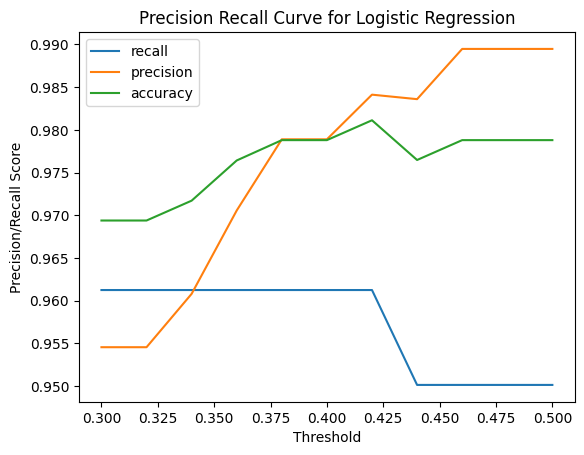

In [54]:
pred_lr_th, actual_lr_th, accuracy_lr_th, precision_lr_th, recall_lr_th, threshold_lr = evaluator_diff_th(X_train, Y_train, LR)

plt.title("Precision Recall Curve for Logistic Regression")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall Score")
plt.plot(threshold_lr, recall_lr_th, label='recall')
plt.plot(threshold_lr, precision_lr_th, label='precision')
plt.plot(threshold_lr, accuracy_lr_th, label='accuracy')
plt.legend()
plt.show()

When you run the code below, a graph visualisation will be presented to show the effect of varying threshold on precision, recall, and accuracy values for the k-nearest Neighbors Model


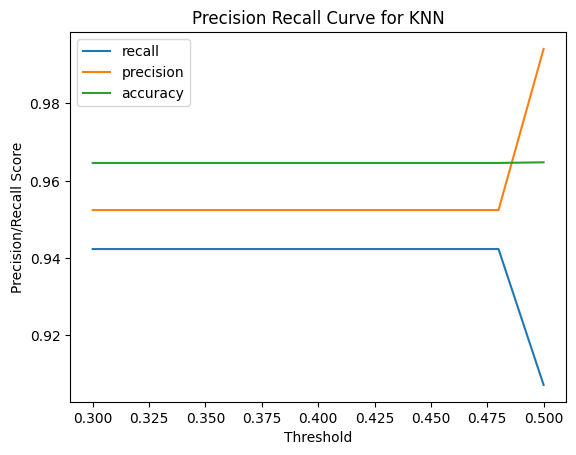

In [53]:
pred_knn_th, actual_knn_th, accuracy_knn_th, precision_knn_th, recall_knn_th, threshold_knn = evaluator_diff_th(X_train, Y_train, knn)

plt.title("Precision Recall Curve for KNN")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall Score")
plt.plot(threshold_knn, recall_knn_th, label='recall')
plt.plot(threshold_knn, precision_knn_th, label='precision')
plt.plot(threshold_knn, accuracy_knn_th, label='accuracy')
plt.legend()
plt.show()

In [42]:
#Recall Optimiser Function For Neural Network
def nn_evaluator_diff_th(X, Y, model):
    kf = KFold(10, shuffle=True, random_state=1)
    pred = np.array([])
    actual = np.array([])
    accuracy = np.array([])
    precision = np.array([])
    recall = np.array([])
    threshold = np.array([])
    for k in range(30,51,2):
        pred_n = np.array([])
        actual_n = np.array([])
        accuracy_n = np.array([])
        precision_n = np.array([])
        recall_n = np.array([])
        for train, test in kf.split(X):
            x_train, y_train, x_test, y_test = X[train], Y[train], X[test], Y[test]
            model.fit(x_train,y_train,batch_size = 1,epochs = 10,verbose = 0)
            pred_i = model.predict(x_test) > k/100
            pred_n = np.append(pred_n, pred_i)
            actual_n = np.append(actual_n, y_test)
            accuracy_n = np.append(accuracy_n, [accuracy_score(y_test, pred_i)])
            precision_n = np.append(precision_n, [precision_score(y_test, pred_i)])
            recall_n = np.append(recall_n, [recall_score(y_test, pred_i)])
        pred = np.append(pred, pred_n)
        actual = np.append(actual, actual_n)
        accuracy = np.append(accuracy, [accuracy_n.mean()])
        precision = np.append(precision, [precision_n.mean()])
        recall = np.append(recall, [recall_n.mean()])
        threshold = np.append(threshold, [k/100])
    return pred, actual, accuracy, precision, recall, threshold

When you run the code below, a graph visualisation will be presented to show the effect of varying threshold on precision, recall, and accuracy values for the Neural Network Model

2/2 [==============================] - 0s 5ms/step


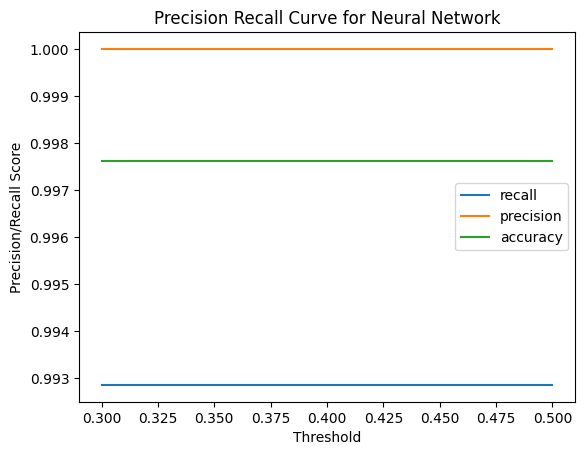

In [43]:
pred_nn_th, actual_nn_th, accuracy_nn_th, precision_nn_th, recall_nn_th, threshold = nn_evaluator_diff_th(X_train, Y_train, nn_model)

plt.title("Precision Recall Curve for Neural Network")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall Score")
plt.plot(threshold, recall_nn_th, label='recall')
plt.plot(threshold, precision_nn_th, label='precision')
plt.plot(threshold, accuracy_nn_th, label='accuracy')
plt.legend()
plt.show()